# IMPORTING PACKAGES

In [1]:
import skimage.io as io
import skimage.filters as skfl
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Defining Sum of Squared Differences and normalized Cross-Correlation functions

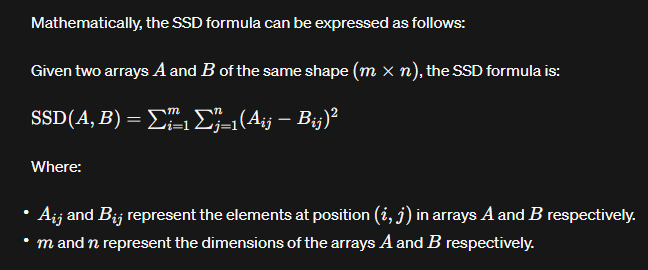

Template Matching:  
In template matching, SSD is used to find the best match between a template image and a larger image by minimizing the sum of squared differences over all possible positions.   
It helps identify regions in the larger image that closely resemble the template.  

In [2]:
# Define the SSD function
def SSD(A, B):
    return np.sum(np.sum((A - B) ** 2))

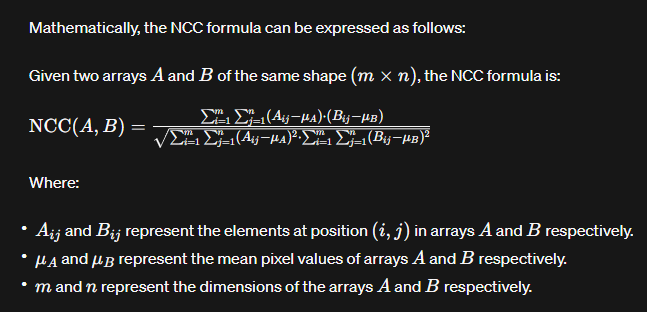

Feature Matching:  
NCC is widely used in feature-based matching algorithms to measure the similarity between feature descriptors extracted from key points in images.   
It helps find corresponding features across different images for tasks such as image stitching, object recognition, and image retrieval.  

In [3]:
# Define the NCC function
def NCC(A, B):
    top = np.sum((A - np.mean(A)) * (B - np.mean(B)))
    bottom = np.sum(np.sqrt((np.sum((A - np.mean(A)) ** 2)) * (np.sum((B - np.mean(B)) ** 2))))
    return top / (bottom + 1)

## Defining Channel Alignment function

Input Parameters:  
The function takes two image channels, channel1 and channel2, as input.  
These channels are assumed to be numpy arrays representing grayscale images or portions thereof.  

Cross-correlation in the Frequency Domain:  
The function performs cross-correlation between the two channels in the frequency domain.  
This is done using the Fast Fourier Transform (FFT) to convert the images from the spatial domain to the frequency domain.  
The np.fft.fft2 function computes the 2-dimensional FFT of each channel.  
The np.conj function computes the complex conjugate of the FFT of channel2.  
The element-wise multiplication np.fft.fft2(channel1) * np.conj(np.fft.fft2(channel2)) computes the cross-power spectrum,  
 which captures the correlation between the frequency components of the two channels.  

Inverse FFT and Shift:  
The inverse FFT (np.fft.ifft2) is applied to the result of the multiplication to obtain the cross-correlation matrix in the spatial domain.    
np.fft.fftshift is used to shift the zero frequency component to the center of the array, which is a common practice in FFT-based processing.  

Finding the Maximum Correlation:  
The function identifies the location of the maximum correlation in the cross-correlation matrix using np.argmax.  
np.unravel_index converts the flattened index of the maximum correlation value into the corresponding index coordinates in the matrix.  

Computing the Shift:  
The function calculates the shift needed to align the two channels based on the location of the maximum correlation.    
It subtracts half of the height and width of the channel from the peak location to obtain the shift relative to the center of the channel.    
Return Value: The function returns the computed shift, which indicates how much channel2 needs to be shifted to align it with channel1.    

In [4]:
def align_channels(channel1, channel2):
    # Perform cross-correlation between the two channels
    result = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(channel1) * np.conj(np.fft.fft2(channel2))))

    # Find the location of the maximum correlation
    peak_loc = np.unravel_index(np.argmax(result), result.shape)

    # Compute the shift
    height, width = channel1.shape
    shift = (peak_loc[0] - height // 2, peak_loc[1] - width // 2)

    return shift

## Defining a Channel Prcessor function that will split and align images based on the above functions

Splitting Channels:  
The function first splits the input image img into blue, green, and red channels based on the height parameter.  
The image is assumed to have the blue channel in the first height rows, the green channel in the next height rows, and the red channel in the last height rows.  

Calculating Similarity Measures:  
The function computes the SSD values and NCC values between pairs of channels (e.g., between blue and green, blue and red, green and red).  
SSD measures the sum of squared differences between corresponding pixel values of two channels.  
NCC measures the normalized cross-correlation coefficient between corresponding pixel values of two channels.  

Alignment:  
The function aligns the green and red channels with the blue channel. This alignment is done by computing shifts between the channels using the align_channels function.  
The alignment shifts are applied to the green and red channels using np.roll.  

Stacking Aligned Channels:  
After alignment, the function stacks the aligned red, green, and blue channels back together to form the aligned image.  
The red and green channels are aligned with respect to the blue channel.  

Displaying Aligned Image:  
The aligned image is displayed using plt.imshow.  
The axis is turned off using plt.axis('off') to remove axis ticks and labels.  

Printing Similarity Measures:  
The SSD and NCC values between channels are printed for analysis.  

In [5]:
def channel_processor(img,height):
    # Split the image into blue, green, and red channels
    B = img[:height]
    G = img[height:2 * height]
    R = img[2 * height:3 * height]

    # Compute the SSD values between the channels
    ssd_B_G = SSD(B, G)
    ssd_B_R = SSD(B, R)
    ssd_G_R = SSD(G, R)

    # Compute the NCC values between the channels
    ncc_B_G = NCC(B, G)
    ncc_B_R = NCC(B, R)
    ncc_G_R = NCC(G, R)

    # Convert SSD and NCC values to strings
    ssd_text = f"SSD - R: ({ssd_B_R}), G: ({ssd_B_G}), B: ({ssd_G_R})"
    ncc_text = f"NCC - R: ({ncc_B_R}), G: ({ncc_B_G}), B: ({ncc_G_R})"

    print(ssd_text)
    print(ncc_text)

    # Align green and red channels with the blue channel
    green_shift = align_channels(B, G)
    red_shift = align_channels(B, R)

    # Apply shifts to green and red channels
    aligned_G = np.roll(G, green_shift, axis=(0, 1))
    aligned_R = np.roll(R, red_shift, axis=(0, 1))

    # Stack the aligned channels back together
    aligned_img = np.dstack([aligned_R, aligned_G, B])

    # Display the resulting image
    plt.imshow(aligned_img)
    plt.axis('off')
    plt.show()

## Iterating through data folder which contains images

SSD - R: (13711670), G: (13700224), B: (10614478)
NCC - R: (0.5628557366131623), G: (0.6327509927495462), B: (0.7009404141786733)


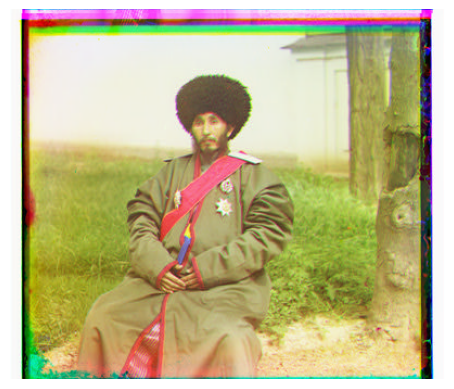

SSD - R: (13696159), G: (13414059), B: (14004806)
NCC - R: (0.07569717929218113), G: (0.6612949771866512), B: (0.35004021281253533)


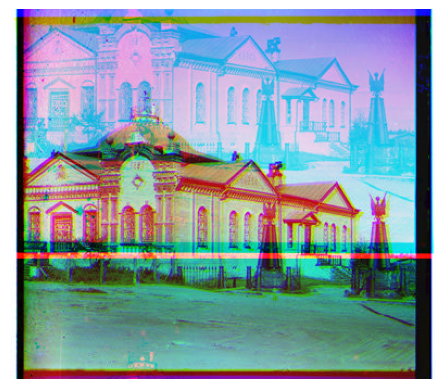

SSD - R: (13118325), G: (13464786), B: (10687759)
NCC - R: (0.6728786069840302), G: (0.7488156692612229), B: (0.7741564972667058)


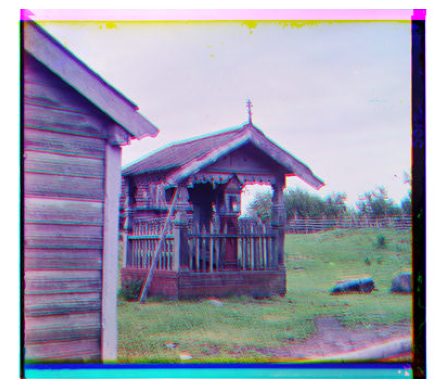

SSD - R: (13982878), G: (14125775), B: (13321555)
NCC - R: (0.3099915285610129), G: (0.6586308275496169), B: (0.6074308112533423)


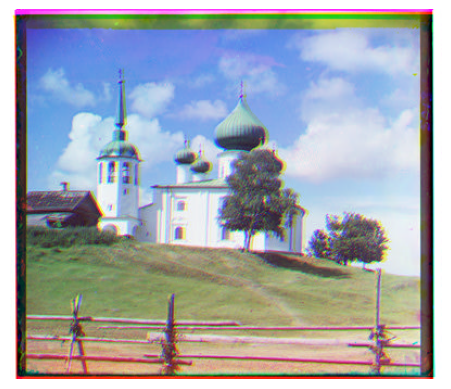

SSD - R: (14713409), G: (13738474), B: (10061819)
NCC - R: (0.6309331673652665), G: (0.8179569209667539), B: (0.8213510379516291)


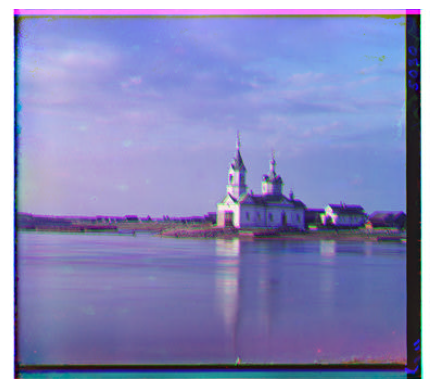

SSD - R: (14077682), G: (12691044), B: (12149808)
NCC - R: (0.5160708400018376), G: (0.734997850757498), B: (0.7586172830531267)


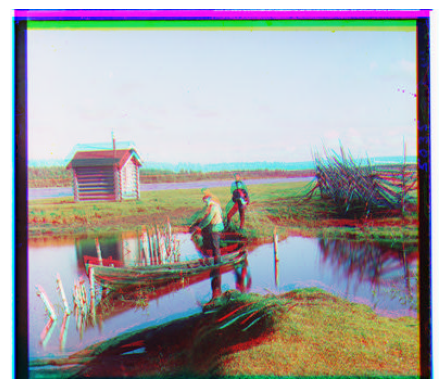

SSD - R: (12941149), G: (12382322), B: (12733325)
NCC - R: (0.40076594084782746), G: (0.6565640805176362), B: (0.7203263556933445)


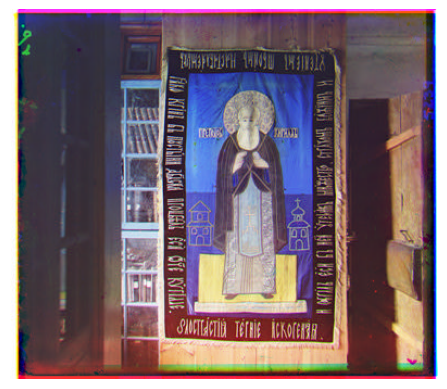

SSD - R: (11342663), G: (13586604), B: (14125047)
NCC - R: (0.36186802425573766), G: (0.7377598141559186), B: (0.6533815250960193)


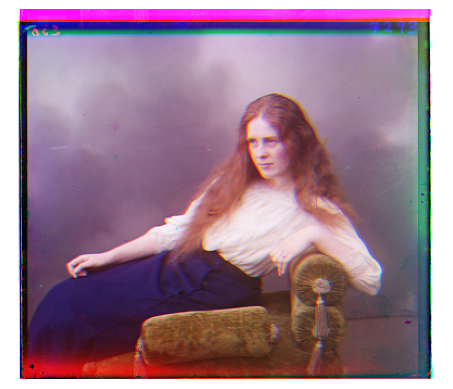

SSD - R: (13210230), G: (12106814), B: (12333182)
NCC - R: (0.3536310726388095), G: (0.6107131377500843), B: (0.6690601344126376)


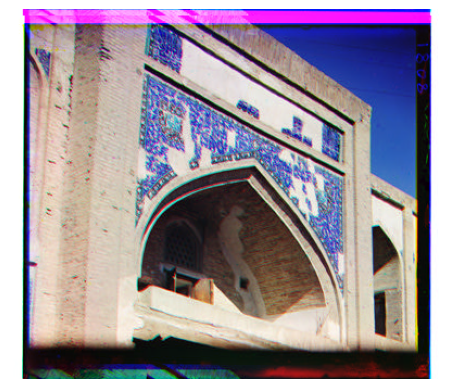

SSD - R: (13949124), G: (13975838), B: (13881986)
NCC - R: (0.26321095312563847), G: (0.5188157935174654), B: (0.5241614534797273)


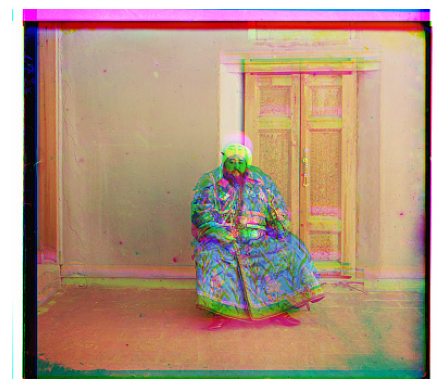

In [6]:
# Load the image
for i in range(1,11):
    img = io.imread(f"./data/{i}.jpg")
    height = int(len(img) / 3)

    #Passing height and image to the channel_processor function
    channel_processor(img,height)